In [1]:
import lineapy

## Phase: Data exploration

As my initial task I'm tasked with exploring how ML could complement our existing business, specifically by predicting the eventual sales price. We have some loyal clients who want to sell with us, a more local shop, than Zillow---we have just relied on realtor known how, but the new COVID trends really threw us off track and we are seeing if the models would pick up the signals more than we can.

My immediate goal is to build a model to predic the sales price. I'm going to check out the data and see if there are some patterns for the algorithm to leverage.

In [2]:
import pandas as pd
training_data = pd.read_csv("data/ames_train_cleaned.csv")

In [3]:
training_data.head(10)

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,TotalBathrooms
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,5,2010,WD,Normal,204900,2.0
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300,1.0
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900,1.5
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,4,2010,WD,Normal,254100,3.5
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700,2.5
5,6,527105030,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,6,2010,WD,Normal,205300,2.5
6,8,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,...,NaN,NaN,NaN,0,1,2010,WD,Normal,201400,2.0
7,9,527146030,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,3,2010,WD,Normal,246500,3.0
8,12,527165230,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,...,NaN,GdPrv,Shed,500,3,2010,WD,Normal,174900,3.0
9,13,527166040,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,5,2010,WD,Normal,170300,2.5


In [4]:
# NBVAL_SKIP
lineapy.visualize()

Before I plot anything, I want to get a sense of the null values

In [5]:
training_data['Lot_Area'].isnull().sum()

0

In [6]:
training_data['MS_Zoning'].isnull().sum()

0

In [7]:
len(training_data)

1998

We can drop "Pool_QC" and Misc_Feature" since they are mostly nulls

In [8]:
cleaned_data = training_data.drop(['Pool_QC', 'Misc_Feature'], axis=1)

In [9]:
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

My sense is that the Living Area is a big predictor for sale price, maybe followed by the Garage Area.

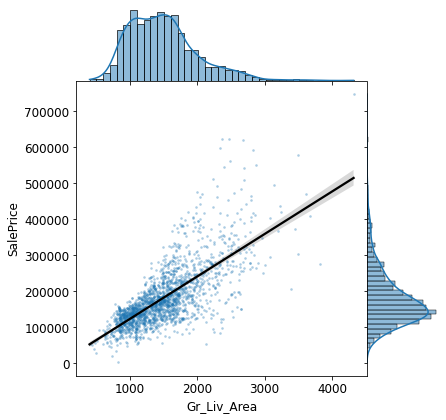

In [10]:
sns.jointplot(
    x='Gr_Liv_Area', 
    y='SalePrice', 
    data=cleaned_data,
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={
        's': 3,
        'alpha': 0.25
    },
    line_kws={
        'color': 'black'
    }
);

I see that the trend starts to dilute, so I want to remove the larger values for now.

In [11]:
# NBVAL_IGNORE_OUTPUT
cleaned_data = cleaned_data[cleaned_data['Gr_Liv_Area']  < 3000]
cleaned_data

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Screen_Porch,Pool_Area,Fence,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,TotalBathrooms
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,0,NaN,0,5,2010,WD,Normal,204900,2.0
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,120,0,MnPrv,0,6,2010,WD,Normal,95300,1.0
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,0,NaN,12500,6,2010,WD,Normal,181900,1.5
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,0,NaN,0,4,2010,WD,Normal,254100,3.5
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,0,MnPrv,0,3,2010,WD,Normal,199700,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,2925,923251180,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,...,0,0,NaN,0,9,2006,WD,Abnorml,124900,2.0
1994,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,0,GdPrv,0,3,2006,WD,Normal,136500,2.0
1995,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,0,MnPrv,0,6,2006,WD,Normal,137000,2.0
1996,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,0,MnPrv,700,7,2006,WD,Normal,137600,1.5


In [12]:
print("Number of records removed:", len(training_data) - len(cleaned_data))

Number of records removed: 15


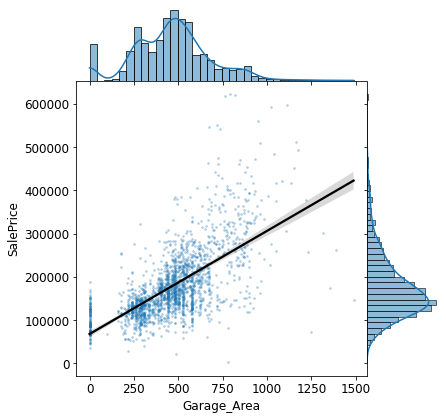

In [13]:
sns.jointplot(
    x='Garage_Area', 
    y='SalePrice', 
    data=cleaned_data,
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={
        's': 3,
        'alpha': 0.25
    },
    line_kws={
        'color': 'black'
    }
);

In [14]:
# NBVAL_IGNORE_OUTPUT
cleaned_data = cleaned_data[cleaned_data['Garage_Area']  < 1250]
cleaned_data

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Screen_Porch,Pool_Area,Fence,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,TotalBathrooms
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,0,NaN,0,5,2010,WD,Normal,204900,2.0
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,120,0,MnPrv,0,6,2010,WD,Normal,95300,1.0
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,0,NaN,12500,6,2010,WD,Normal,181900,1.5
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,0,NaN,0,4,2010,WD,Normal,254100,3.5
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,0,MnPrv,0,3,2010,WD,Normal,199700,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,2925,923251180,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,...,0,0,NaN,0,9,2006,WD,Abnorml,124900,2.0
1994,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,0,GdPrv,0,3,2006,WD,Normal,136500,2.0
1995,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,0,MnPrv,0,6,2006,WD,Normal,137000,2.0
1996,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,0,MnPrv,700,7,2006,WD,Normal,137600,1.5


In [15]:
print("Number of records removed:", len(training_data) - len(cleaned_data))

Number of records removed: 19


In [16]:
lineapy.visualize()

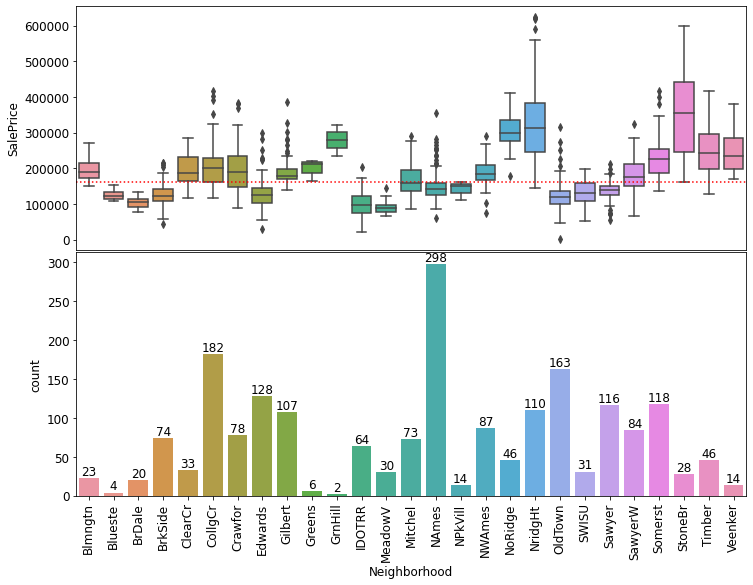

In [17]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='Neighborhood',
    y='SalePrice',
    data=cleaned_data.sort_values('Neighborhood'),
    ax=axs[0]
)

sns.countplot(
    x='Neighborhood',
    data=cleaned_data.sort_values('Neighborhood'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=cleaned_data['SalePrice'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

I verify that Neighborhood is a very promising way to go forward.

However, in order to be able to also use linear models, I must map these neighborhoods back into numeric values (one hot encoding).

In [18]:
from pandas.api.types import CategoricalDtype

from sklearn.feature_extraction import DictVectorizer

vec_enc = DictVectorizer()
vec_enc.fit(cleaned_data[['Neighborhood']].to_dict(orient='records'))
Neighborhood_data = vec_enc.transform(cleaned_data[['Neighborhood']].to_dict(orient='records')).toarray()
Neighborhood_cats = vec_enc.get_feature_names()
Neighborhood = pd.DataFrame(Neighborhood_data, columns=Neighborhood_cats)
Neighborhood = Neighborhood.drop(['Neighborhood=GrnHill', 'Neighborhood=Landmrk'], axis=1, errors='ignore')
cleaned_data = pd.concat([cleaned_data, Neighborhood], axis=1)
cleaned_data = cleaned_data.drop(columns=Neighborhood_cats[0])

In sum, the columns that I should focus on is:

- Gr_Liv_Area
- Garage_Area
- regex='Neightborhood'

In [19]:
!mkdir -p outputs
cleaned_data.filter(
    regex="Neighborhood=.|Gr_Liv_Area|Garage_Area|SalePrice"
).to_csv("outputs/cleaned_data_housing.csv", index=False)

## Task 1: Pipeline

I want to re-run this when I have new data---i.e. when `ames_train_cleaned.csv` updates. However, I realize that I have to go to the `Exploration_without_Linea.ipynb` file to extract the process. Try to lift it manually into a airflow job.

In [20]:
# NBVAL_SKIP
# clear airflow dags to demonstrate that we are creating these dags
!rm /tmp/airflow_home/dags/*.py

zsh:1: no matches found: /tmp/airflow_home/dags/*.py


In [21]:
artifact = lineapy.save(lineapy.file_system, "cleaned_data_housing")

In [22]:
# NBVAL_SKIP
artifact.visualize()

In [23]:
# NBVAL_SKIP
!rm outputs/cleaned_data_housing.csv

In [24]:
# NBVAL_IGNORE_OUTPUT
artifact.to_airflow();

Generated python module cleaned_data_housing.py

Added Airflow DAG named cleaned_data_housing_dag. Start a run from the Airflow UI or CLI.

Generated Dockerfile cleaned_data_housing_Dockerfile

Generated requirements file cleaned_data_housing_requirements.txt

In [25]:
print(artifact.code)

import pandas as pd
training_data = pd.read_csv("data/ames_train_cleaned.csv")
cleaned_data = training_data.drop(['Pool_QC', 'Misc_Feature'], axis=1)
cleaned_data = cleaned_data[cleaned_data['Gr_Liv_Area']  < 3000]
cleaned_data = cleaned_data[cleaned_data['Garage_Area']  < 1250]
from sklearn.feature_extraction import DictVectorizer
vec_enc = DictVectorizer()
vec_enc.fit(cleaned_data[['Neighborhood']].to_dict(orient='records'))
Neighborhood_data = vec_enc.transform(cleaned_data[['Neighborhood']].to_dict(orient='records')).toarray()
Neighborhood_cats = vec_enc.get_feature_names()
Neighborhood = pd.DataFrame(Neighborhood_data, columns=Neighborhood_cats)
Neighborhood = Neighborhood.drop(['Neighborhood=GrnHill', 'Neighborhood=Landmrk'], axis=1, errors='ignore')
cleaned_data = pd.concat([cleaned_data, Neighborhood], axis=1)
cleaned_data = cleaned_data.drop(columns=Neighborhood_cats[0])
cleaned_data.filter(
    regex="Neighborhood=.|Gr_Liv_Area|Garage_Area|SalePrice"
).to_csv("outputs/cleaned

If we wait for airflow to run, we can see that the CSV is now re-computed:

In [26]:
# NBVAL_IGNORE_OUTPUT
!head -n 10 outputs/cleaned_data_housing.csv

head: outputs/cleaned_data_housing.csv: No such file or directory
